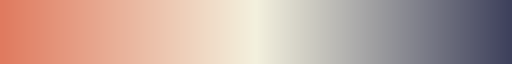

In [1]:
from scipy import odr
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.colors as mcolors
import plotly.express as px, plotly.graph_objects as go
import os
import seaborn as sns
from matplotlib.colors import to_rgba
from scipy.stats import mannwhitneyu

pd.options.mode.chained_assignment = None
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 13  
colors = ["#e07a5f", "#f4f1de", "#3d405b"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
custom_cmap

## Breast cancer samples

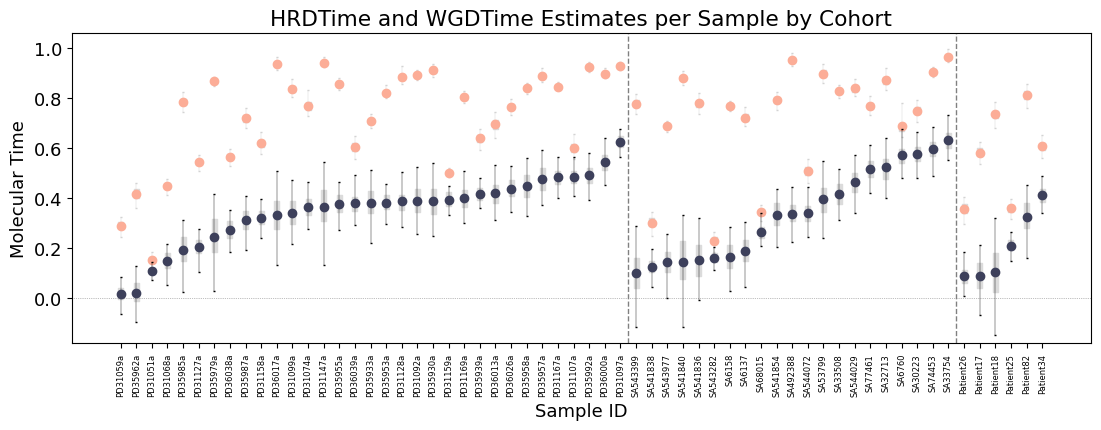

In [2]:
import pandas as pd, matplotlib.pyplot as plt

# File paths and colors
files = {
    'SCANB': "../../data/output/May27_TimingRun/SCANB_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv",
    'PCAWG': "../../data/output/May27_TimingRun/PCAWG_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv",
    'INFORM': "../../data/output/May27_TimingRun/INFORM_Breast_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv"
}

x_pos, cohort_boundaries, dfs, exclusion_reasons = 0, [], [], {}

# Load metadata
metadata_path = "../../data/metadata/pan_metadata_v5.csv"
meta = pd.read_csv(metadata_path)
meta.set_index('sample', inplace=True)

# These are the sample IDs that we want to exclude based on QC and signature accuracy
samples_to_exclude = [
    'PD31145a', 'PD35929a', 'PD36006a', 'PD35926a', 'PD35935a', 'PD36067a', 'PD35990a',
    'PD31129a', 'PD31155a', 'PD35941a', 'PD36024a', 'PD31044a', 'PD31171a', 'PD31178a',
    'PD36054a', 'PD31056a', 
    '7456abd5-303e-4e6f-bf4e-47efefc7310f', 'fc806c50-2f6e-418d-e040-11ac0d485f01',
    '5dbf3203-ce73-41e4-bf9a-32fc856f73f5', '418e916b-7a4e-4fab-8616-15dcec4d79f8',
    'f393bb07-270c-2c93-e040-11ac0d484533', 'b752b444-f033-4be4-9d24-e5e80b4181af',
    '207f8a42-5b05-4876-b0ae-ebfaeea27844', 'd5372745-95cf-4572-a6e7-e7f5b796911a',
    'f393bb0c-4178-ca4a-e040-11ac0d48455f', '987528ac-437a-4eb8-a335-4f2076d5c006',
    'fc8130df-8ec8-5b1e-e040-11ac0d485e06', 'fca6150f-d555-a29e-e040-11ac0d4873b2',
    '43f7a2e0-fec9-4e43-872d-18c6c946fa17', 'Patient33', 'Patient101'
]

for k, f in files.items():
    df = pd.read_csv(f)[[
        'ID',
        'HRDTime', 'HRDTime_ci_lo', 'HRDTime_ci_hi', 'HRDTime_ci_IQR_lo', 'HRDTime_ci_IQR_hi',
        'WGDTime', 'WGDTime_ci_lo', 'WGDTime_ci_hi', 'WGDTime_ci_IQR_lo', 'WGDTime_ci_IQR_hi'
    ]].dropna()
    invalid_mask = df['ID'].isin(samples_to_exclude)
    excluded_ids = df.loc[invalid_mask, 'ID'].tolist()

    if excluded_ids:
        #print(f"\nRemoved {len(excluded_ids)} samples from {k}:", excluded_ids)
        for sid in excluded_ids:
            reasons = []
            if sid in meta.index:
                if meta.loc[sid].get('timerQC_fail'): reasons.append("timerQC_fail")
                if meta.loc[sid].get('del.mh.prop', 1.0) < 0.4: reasons.append("del.mh.prop < 0.4")
                if meta.loc[sid].get('HRDetect.bootstrap.score.percentile.5', 1.0) < 0.7: reasons.append("HRDetect < 0.7")
            else: reasons.append("not in metadata")
            exclusion_reasons[sid] = reasons

    df = df[~invalid_mask].sort_values('HRDTime').reset_index(drop=True)
    df['Dataset'], df['x'] = k, range(x_pos, x_pos + len(df))
    x_pos += len(df); cohort_boundaries.append(x_pos); dfs.append(df)

df_all = pd.concat(dfs).reset_index(drop=True)
df_all = df_all[~df_all['ID'].isin(samples_to_exclude)].reset_index(drop=True)
df_all['x'] = range(len(df_all))

# Replace PCAWG IDs with sample.display where available
def get_display_name(sample_id):
    if sample_id in meta.index and pd.notna(meta.loc[sample_id].get('sample.display')):
        return meta.loc[sample_id]['sample.display']
    return sample_id

# Apply only to PCAWG cohort
mask_pcawg = df_all['Dataset'] == 'PCAWG'
df_all.loc[mask_pcawg, 'ID'] = df_all.loc[mask_pcawg, 'ID'].apply(get_display_name)

# === Plotting ===
plt.figure(figsize=(14, 4.5))
for k, g in df_all.groupby('Dataset'):
    plt.errorbar(g['x'], g['HRDTime'], yerr=[g['HRDTime_ci_lo'], g['HRDTime_ci_hi']],
                 fmt='o', color='#3d405b', ecolor='k', elinewidth=0.3, capsize=1, markersize=6, label=f"{k} HRDTime", zorder=3)
    plt.errorbar(g['x'], g['WGDTime'], yerr=[g['WGDTime_ci_lo'], g['WGDTime_ci_hi']],
                 fmt='o', color='#fcad97', ecolor='lightgrey', elinewidth=0.3, capsize=1, markersize=6, label=f"{k} WGDTime")
    for _, r in g.iterrows():
        plt.fill_between([r['x'] - 0.16, r['x'] + 0.16],
                         [r['HRDTime'] - r['HRDTime_ci_IQR_lo']]*2,
                         [r['HRDTime'] + r['HRDTime_ci_IQR_hi']]*2, color='#dbdbdb', alpha=1, zorder=0)
        plt.fill_between([r['x'] - 0.16, r['x'] + 0.16],
                         [r['WGDTime'] - r['WGDTime_ci_IQR_lo']]*2,
                         [r['WGDTime'] + r['WGDTime_ci_IQR_hi']]*2, color='#dbdbdb', alpha=1, zorder=0)

for b in cohort_boundaries[:-1]:
    plt.axvline(x=b - 0.5, color='grey', linestyle='--', linewidth=1)

xticks = plt.xticks(df_all['x'], df_all['ID'], rotation=90, fontsize=6)
plt.ylim(-0.18, 1.06)
plt.ylabel("Molecular Time"); plt.xlabel("Sample ID")
plt.title("HRDTime and WGDTime Estimates per Sample by Cohort")
plt.axhline(y=0, color='grey', linestyle=':', linewidth=0.5)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.savefig("../../data/output/output_plots/Breast_HDRTimer_MolecularTime.pdf", format='pdf', bbox_inches='tight')
plt.show()

# ==== Exclusion Reasons ==== (Uncomment to print on the console)
# if exclusion_reasons:
#   print("\nDetailed exclusion reasons:")
#    for sid, reasons in exclusion_reasons.items():
#        print(f"{sid}: {'; '.join(reasons)}")
#else:
#    print("\nNo excluded samples found with filtering criteria.")


# === Removal Summary Table ===

all_ids = set()
for f in files.values():
    all_ids.update(pd.read_csv(f)['ID'].dropna().tolist())

records = [{'sample_id': sid, 'removed': sid in samples_to_exclude,
            'reasons': '; '.join(exclusion_reasons.get(sid, [])) if sid in samples_to_exclude else ''} for sid in all_ids]
removal_df = pd.DataFrame(records)
removal_df.to_csv("../../data/output/Breast_cohort_sample_removal_reasons.csv", index=False)


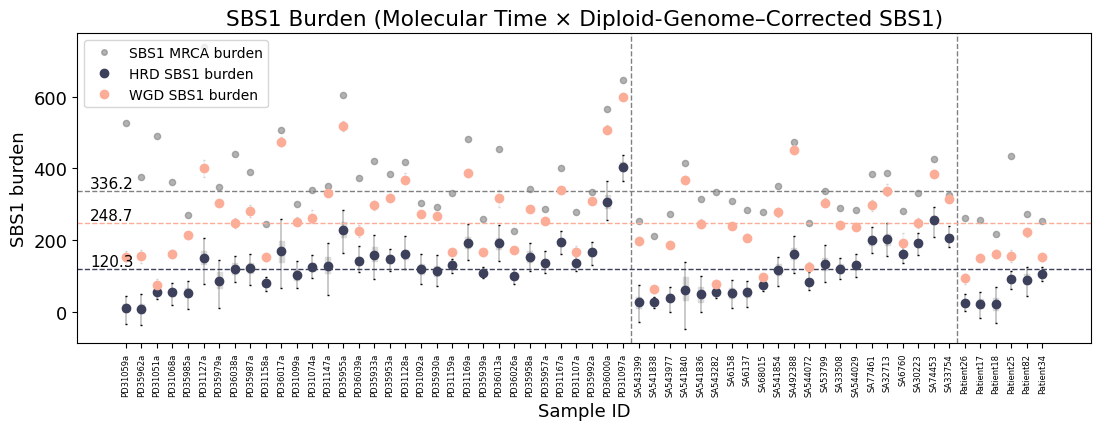

In [27]:
meta = pd.read_csv("../../data/output/All_data_Jun11.csv")
meta.index = meta['ID']
sbs1_path = "../../data/output/PCAWG_SCANB_INFORM_SBS1_Age_plot.csv"
sbs1_df = pd.read_csv(sbs1_path)
sbs1_df = sbs1_df.rename(columns={'aliquot_id': 'ID'})[['ID', 'scaled_SBS1']]
sbs1_df['SBS1_total'] = sbs1_df['scaled_SBS1'] * 2 * 3000 

def get_display_name(sample_id):
    if sample_id in meta.index:
        display_name = meta.at[sample_id, 'sample.display']
        if pd.notna(display_name):
            return display_name
    return sample_id


sbs1_df['ID_display'] = sbs1_df['ID'].apply(get_display_name)

# Remove excluded samples (use original IDs, not display)
sbs1_df = sbs1_df[~sbs1_df['ID'].isin(samples_to_exclude)].reset_index(drop=True)

# Now merge on display IDs instead of raw IDs
df_all['ID_display'] = df_all['ID'].apply(get_display_name)

df_all_burden = pd.merge(df_all, sbs1_df, left_on='ID_display', right_on='ID_display')

# Calculate SBS1 burden using SBS1_total
df_all_burden['WGD_SBS1_burden'] = df_all_burden['WGDTime'] * df_all_burden['SBS1_total']
df_all_burden['HRD_SBS1_burden'] = df_all_burden['HRDTime'] * df_all_burden['SBS1_total']

# CI and IQR calculations
df_all_burden['WGD_SBS1_ci_lo'] = df_all_burden['WGDTime_ci_lo'] * df_all_burden['SBS1_total']
df_all_burden['WGD_SBS1_ci_hi'] = df_all_burden['WGDTime_ci_hi'] * df_all_burden['SBS1_total']
df_all_burden['HRD_SBS1_ci_lo'] = df_all_burden['HRDTime_ci_lo'] * df_all_burden['SBS1_total']
df_all_burden['HRD_SBS1_ci_hi'] = df_all_burden['HRDTime_ci_hi'] * df_all_burden['SBS1_total']

df_all_burden['WGD_SBS1_iqr_lo'] = df_all_burden['WGDTime_ci_IQR_lo'] * df_all_burden['SBS1_total']
df_all_burden['WGD_SBS1_iqr_hi'] = df_all_burden['WGDTime_ci_IQR_hi'] * df_all_burden['SBS1_total']
df_all_burden['HRD_SBS1_iqr_lo'] = df_all_burden['HRDTime_ci_IQR_lo'] * df_all_burden['SBS1_total']
df_all_burden['HRD_SBS1_iqr_hi'] = df_all_burden['HRDTime_ci_IQR_hi'] * df_all_burden['SBS1_total']

# Plotting
plt.figure(figsize=(14, 4.5))
x = df_all_burden.index

# Plot SBS1 MRCA burden as grey dots
plt.scatter(x, df_all_burden['SBS1_total'], color='grey', alpha=0.6, s=20, zorder=0)

for _, r in df_all_burden.iterrows():
    # HRD point
    plt.errorbar(r.name, r['HRD_SBS1_burden'],
                 yerr=[[r['HRD_SBS1_ci_lo']], [r['HRD_SBS1_ci_hi']]],
                 fmt='o', color='#3d405b', ecolor='k', elinewidth=0.3, capsize=1, markersize=6, label='_nolegend_')
    plt.fill_between([r.name - 0.16, r.name + 0.16],
                     r['HRD_SBS1_burden'] - r['HRD_SBS1_iqr_lo'],
                     r['HRD_SBS1_burden'] + r['HRD_SBS1_iqr_hi'],
                     color='#dbdbdb', alpha=1, zorder=0)

    # WGD point
    plt.errorbar(r.name, r['WGD_SBS1_burden'],
                 yerr=[[r['WGD_SBS1_ci_lo']], [r['WGD_SBS1_ci_hi']]],
                 fmt='o', color='#fcad97', ecolor='lightgrey', elinewidth=0.3, capsize=1, markersize=6, label='_nolegend_')
    plt.fill_between([r.name - 0.16, r.name + 0.16],
                     r['WGD_SBS1_burden'] - r['WGD_SBS1_iqr_lo'],
                     r['WGD_SBS1_burden'] + r['WGD_SBS1_iqr_hi'],
                     color='#dbdbdb', alpha=1, zorder=0)

for b in cohort_boundaries[:-1]:
    plt.axvline(x=b - 0.5, color='grey', linestyle='--', linewidth=1)

# Median lines
median_WGD_burden = df_all_burden['WGD_SBS1_burden'].median()
median_HRD_burden = df_all_burden['HRD_SBS1_burden'].median()
plt.axhline(y=median_WGD_burden, color='#fcad97', linestyle='--', linewidth=1, label='Median WGD SBS1 burden')
plt.axhline(y=median_HRD_burden, color='#3d405b', linestyle='--', linewidth=1, label='Median HRD SBS1 burden')
median_MRCA_burden = df_all_burden['SBS1_total'].median()
plt.axhline(y=median_MRCA_burden, color='grey', linestyle='--', linewidth=1, label='Median SBS1 MRCA burden')
plt.text(0.5, median_MRCA_burden, f"{median_MRCA_burden:.1f}",
         va='bottom', ha='right', color='k', fontsize=11)


plt.text(0.5, median_WGD_burden, f"{median_WGD_burden:.1f}", 
         va='bottom', ha='right', color='k', fontsize=11)
plt.text(0.5, median_HRD_burden, f"{median_HRD_burden:.1f}", 
         va='bottom', ha='right', color='k', fontsize=11)

plt.xticks(x, df_all_burden['ID_display'], rotation=90, fontsize=6)
plt.ylabel("SBS1 burden")
plt.xlabel("Sample ID")
plt.title("SBS1 Burden (Molecular Time × Diploid-Genome–Corrected SBS1)")
handles = [
    plt.Line2D([], [], color='grey', marker='o', linestyle='None', markersize=4, alpha=0.6, label='SBS1 MRCA burden'),
    plt.Line2D([], [], color='#3d405b', marker='o', linestyle='None', markersize=6, label='HRD SBS1 burden'),
    plt.Line2D([], [], color='#fcad97', marker='o', linestyle='None', markersize=6, label='WGD SBS1 burden'),
]
plt.legend(handles=handles, loc='upper left', fontsize=10)
plt.tight_layout(rect=[0, 0, 0.8, 1])
#plt.savefig("../../data/output/output_plots/SBS1_burden_HRD_WGD.pdf", format='pdf', bbox_inches='tight')
plt.show()


Median HRDTime by tumor type:
 type
ER+    0.25083
TN     0.37661
Name: HRDTime, dtype: float64
Mann-Whitney U p-value: 6.910e-01


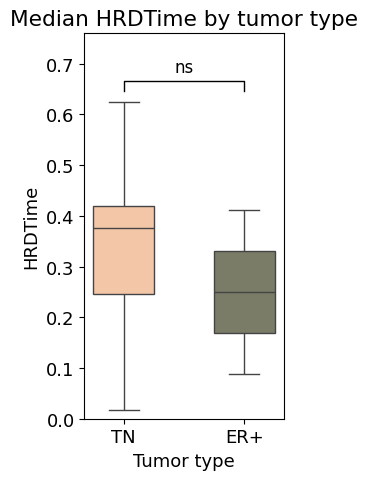

In [24]:
df_all_type = df_all.set_index('ID').join(meta[['type']]).dropna(subset=['type']).reset_index()

# Plot boxplot by tumor type
plt.figure(figsize=(3,5))
ax = sns.boxplot(data=df_all_type, x='type', y='HRDTime',
                 palette={'ER+': '#7C7F65', 'TN': '#FFC49B'},
                 hue='type', width=0.5, fliersize=2, linewidth=1)

# Mann-Whitney U test between types
er_vals = df_all_type.loc[df_all_type['type']=='ER+', 'HRDTime']
tn_vals = df_all_type.loc[df_all_type['type']=='TN', 'HRDTime']
stat, pval = mannwhitneyu(er_vals, tn_vals, alternative='two-sided')

# Print medians and p-value
medians = df_all_type.groupby('type')['HRDTime'].median()
print("Median HRDTime by tumor type:\n", medians)
print(f"Mann-Whitney U p-value: {pval:.3e}")

# Add significance annotation
x1, x2 = 0, 1
y = df_all_type['HRDTime'].max() + 0.02
h = 0.02
col = 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)

if pval < 0.001:
    star = '***'
elif pval < 0.01:
    star = '**'
elif pval < 0.05:
    star = '*'
else:
    star = 'ns'

ax.text((x1+x2)*0.5, y+h+0.01, star, ha='center', va='bottom', color=col, fontsize=12)

plt.ylabel("HRDTime")
plt.xlabel("Tumor type")
plt.ylim(0, 0.76)
plt.title("Median HRDTime by tumor type")
plt.tight_layout()
plt.show()

Median HRD SBS1 burden by tumor type:
 type
ER+     63.471497
TN     124.023945
Name: HRD_SBS1_burden, dtype: float64
Mann-Whitney U p-value: 2.186e-01


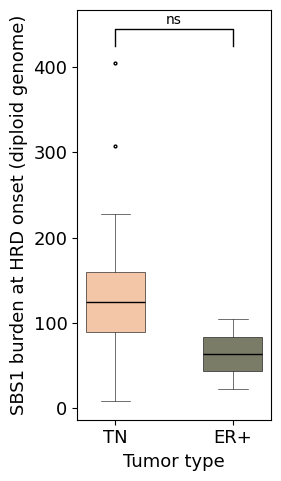

In [26]:
metadata_path = "../../data/metadata/pan_metadata_v5.csv"
meta = pd.read_csv(metadata_path).set_index('sample')

df_burden_type = df_all_burden.set_index('ID_x').join(meta[['type']], how='left').dropna(subset=['type']).reset_index()
df_burden_type = df_burden_type[df_burden_type['type'].isin(['ER+', 'TN'])]

# Plot
plt.figure(figsize=(3,5))
ax = sns.boxplot(
    data=df_burden_type, x='type', y='HRD_SBS1_burden',
    palette={'ER+': '#7C7F65', 'TN': '#FFC49B'},
    width=0.5, fliersize=2, linewidth=1,
    hue='type',
    boxprops=dict(edgecolor='black', linewidth=0.4),
    whiskerprops=dict(color='black', linewidth=0.4),
    capprops=dict(color='black', linewidth=0.4),
    medianprops=dict(color='black'),
    flierprops=dict(markeredgecolor='black', linewidth=0.5)
)

# Mann-Whitney U test
er_vals = df_burden_type.loc[df_burden_type['type']=='ER+', 'HRD_SBS1_burden']
tn_vals = df_burden_type.loc[df_burden_type['type']=='TN', 'HRD_SBS1_burden']
stat, pval = mannwhitneyu(er_vals, tn_vals, alternative='two-sided')

# Print medians and p-value
medians = df_burden_type.groupby('type')['HRD_SBS1_burden'].median()
print("Median HRD SBS1 burden by tumor type:\n", medians)
print(f"Mann-Whitney U p-value: {pval:.3e}")

# Significance annotation
x1, x2 = 0, 1
y = df_burden_type['HRD_SBS1_burden'].max() * 1.05
h = df_burden_type['HRD_SBS1_burden'].max() * 0.05
col = 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)

if pval < 0.001:
    star = '***'
elif pval < 0.01:
    star = '**'
elif pval < 0.05:
    star = '*'
else:
    star = 'ns'

ax.text((x1+x2)*0.5, y+h*1.1, star, ha='center', va='bottom', color=col, fontsize=10)

plt.ylabel("SBS1 burden at HRD onset (diploid genome)")
plt.xlabel("Tumor type")
plt.tight_layout()
plt.savefig("../../data/output/output_plots/hrd_SBS1_burden.pdf", format='pdf', bbox_inches='tight')
plt.show()


## Ovarian Cancer samples

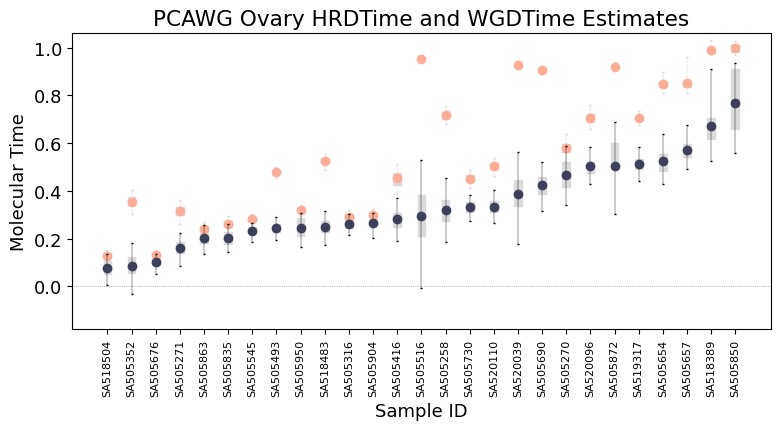

In [ ]:
files = {
    'PCAWG': "../../data/output/May27_TimingRun/PCAWG_Ovary_WGD_HRD_TimingResults_timing_nboot200_0001_only_prob_change_boot_pSub.csv"
}

x_pos, cohort_boundaries, dfs, exclusion_reasons = 0, [], [], {}
# Load metadata
metadata_path = "../../data/metadata/pan_metadata_v5.csv"
meta = pd.read_csv(metadata_path)
meta.set_index('sample', inplace=True)

# Modify this to exclude samples
samples_to_exclude = []

for k, f in files.items():
    df = pd.read_csv(f)[[
        'ID',
        'HRDTime', 'HRDTime_ci_lo', 'HRDTime_ci_hi', 'HRDTime_ci_IQR_lo', 'HRDTime_ci_IQR_hi',
        'WGDTime', 'WGDTime_ci_lo', 'WGDTime_ci_hi', 'WGDTime_ci_IQR_lo', 'WGDTime_ci_IQR_hi'
    ]].dropna()
    invalid_mask = df['ID'].isin(samples_to_exclude)
    excluded_ids = df.loc[invalid_mask, 'ID'].tolist()

    if excluded_ids:
        #print(f"\nRemoved {len(excluded_ids)} samples from {k}:", excluded_ids)
        for sid in excluded_ids:
            reasons = []
            if sid in meta.index:
                if meta.loc[sid].get('timerQC_fail'): reasons.append("timerQC_fail")
                if meta.loc[sid].get('del.mh.prop', 1.0) < 0.4: reasons.append("del.mh.prop < 0.4")
                if meta.loc[sid].get('HRDetect.bootstrap.score.percentile.5', 1.0) < 0.7: reasons.append("HRDetect < 0.7")
            else: reasons.append("not in metadata")
            exclusion_reasons[sid] = reasons

    df = df[~invalid_mask].sort_values('HRDTime').reset_index(drop=True)
    df['Dataset'], df['x'] = k, range(x_pos, x_pos + len(df))
    x_pos += len(df); cohort_boundaries.append(x_pos); dfs.append(df)

df_all = pd.concat(dfs).reset_index(drop=True)
df_all = df_all[~df_all['ID'].isin(samples_to_exclude)].reset_index(drop=True)
df_all['x'] = range(len(df_all))

# Replace PCAWG IDs with sample.display where available
def get_display_name(sample_id):
    if sample_id in meta.index and pd.notna(meta.loc[sample_id].get('sample.display')):
        return meta.loc[sample_id]['sample.display']
    return sample_id

# Apply only to PCAWG cohort
mask_pcawg = df_all['Dataset'] == 'PCAWG'
df_all.loc[mask_pcawg, 'ID'] = df_all.loc[mask_pcawg, 'ID'].apply(get_display_name)

# === Plotting ===
plt.figure(figsize=(10, 4.5))
for k, g in df_all.groupby('Dataset'):
    plt.errorbar(g['x'], g['HRDTime'], yerr=[g['HRDTime_ci_lo'], g['HRDTime_ci_hi']],
                 fmt='o', color='#3d405b', ecolor='k', elinewidth=0.3, capsize=1, markersize=6, label=f"{k} HRDTime", zorder=3)
    plt.errorbar(g['x'], g['WGDTime'], yerr=[g['WGDTime_ci_lo'], g['WGDTime_ci_hi']],
                 fmt='o', color='#fcad97', ecolor='lightgrey', elinewidth=0.3, capsize=1, markersize=6, label=f"{k} WGDTime")
    for _, r in g.iterrows():
        plt.fill_between([r['x'] - 0.16, r['x'] + 0.16],
                         [r['HRDTime'] - r['HRDTime_ci_IQR_lo']]*2,
                         [r['HRDTime'] + r['HRDTime_ci_IQR_hi']]*2, color='#dbdbdb', alpha=1, zorder=0)
        plt.fill_between([r['x'] - 0.16, r['x'] + 0.16],
                         [r['WGDTime'] - r['WGDTime_ci_IQR_lo']]*2,
                         [r['WGDTime'] + r['WGDTime_ci_IQR_hi']]*2, color='#dbdbdb', alpha=1, zorder=0)

for b in cohort_boundaries[:-1]:
    plt.axvline(x=b - 0.5, color='grey', linestyle='--', linewidth=1)

xticks = plt.xticks(df_all['x'], df_all['ID'], rotation=90, fontsize=10)
plt.ylim(-0.18, 1.06)
plt.ylabel("Molecular Time"); plt.xlabel("Sample ID")
plt.title("PCAWG Ovary HRDTime and WGDTime Estimates")
plt.axhline(y=0, color='grey', linestyle=':', linewidth=0.5)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.savefig("../../data/output/output_plots/OVARY_HDRTimer_MolecularTime.pdf", format='pdf', bbox_inches='tight')
plt.show()